# Imports

In [1]:
%%time

from IPython.display import clear_output

! pip install -qq -U transformers
! pip install -qq -U bitsandbytes
! pip install -qq -U accelerate

clear_output()

CPU times: user 672 ms, sys: 143 ms, total: 816 ms
Wall time: 59.7 s


In [2]:
%%time

import warnings
warnings.filterwarnings('ignore')

import gc

from PIL import Image
import matplotlib.pyplot as plt

import torch

import transformers
print(f'transformers version: {transformers.__version__}')

from transformers import (
    AutoModelForCausalLM, AutoTokenizer,
    BitsAndBytesConfig
)
transformers.logging.set_verbosity_error()
transformers.logging.disable_progress_bar()

transformers version: 4.44.2
CPU times: user 2.07 s, sys: 401 ms, total: 2.47 s
Wall time: 4.66 s


# CFG

In [3]:
class CFG:
    ### generation
    max_new_tokens = 200
    
    ### hardware
    device = 'cuda' # 'cuda', 'cpu'

# Model

In [4]:
def get_model():
    
    ### quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type = "nf4",
        bnb_4bit_compute_dtype = torch.float16,
        bnb_4bit_use_double_quant = True,
    )    

    ### model
    model = AutoModelForCausalLM.from_pretrained(
        'BAAI/Bunny-Llama-3-8B-V',
        quantization_config = bnb_config,
        torch_dtype = torch.float16, # float32 for cpu
        device_map = CFG.device,
        trust_remote_code = True
    )

    ### tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        'BAAI/Bunny-Llama-3-8B-V',
        trust_remote_code = True
    )
    
    return model, tokenizer

In [5]:
%%time
model, tokenizer = get_model()
clear_output()

CPU times: user 41.4 s, sys: 38.3 s, total: 1min 19s
Wall time: 8min 12s


In [6]:
gc.collect()

30

In [7]:
model

BunnyLlamaForCausalLM(
  (model): BunnyLlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    

In [19]:
import io
import requests
import PIL
import numpy as np
def read_image(url):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
#     image = np.array(image)
    # Remove alpha channel if neccessary.
#     if image.shape[2] == 4:
#         image = image[:, :, :3]
    return image

# Inference function

In [20]:
def multimodal_inference(
    prompt = '',
    image_path = '',
    model = model,
    tokenizer = tokenizer,
    device = CFG.device
    ):
    
    sys_prompt = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
    
    text_chunks = [tokenizer(chunk).input_ids for chunk in sys_prompt.split('<image>')]

    input_ids = torch.tensor(
        text_chunks[0] + [-200] + text_chunks[1][1:],
        dtype = torch.long
    ).unsqueeze(0).to(device)
    
    image = read_image(image_path)
    
    image_tensor = model.process_images(
        [image],
        model.config
    ).to(dtype = model.dtype, device = device)
    
    print(f'\nInput tensor shape: {image_tensor.shape}\n')
    
    ### inference
    output_ids = model.generate(
        input_ids,
        images = image_tensor,
        max_new_tokens = CFG.max_new_tokens,
        use_cache = True
    )[0]    
    
    response = tokenizer.decode(
        output_ids[input_ids.shape[1]:],
        skip_special_tokens=True
    ).strip()

    print(response)
    print('\n\n')
    
    return response

# Run inference

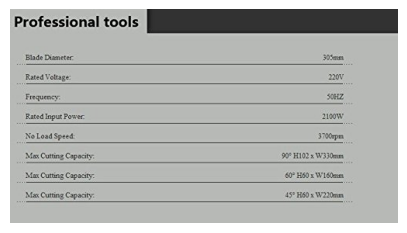

In [27]:

# image_path = '/kaggle/input/book-covers-dataset/book-covers/Natural-History/0000021.jpg'
image_path = 'https://m.media-amazon.com/images/I/417SThj+SrL.jpg'
image_test = read_image(image_path)
# image_test

plt.figure(figsize=(5, 5))
plt.imshow(image_test)
plt.axis('off')
plt.show()

In [28]:
%%time
result = multimodal_inference(
    prompt = 'Please transcribe the text contained in the following image. Provide the exact words as they appear in the image, maintaining the order and format of the text.?',
    image_path = image_path,
    model = model,
    tokenizer = tokenizer,
    device = CFG.device
)


Input tensor shape: torch.Size([1, 3, 384, 384])

Professional Tools
- Blade size: 30mm
- Rated voltage: 230V
- Rated power: 700W
- Rated frequency: 50Hz
- Rated input power: 1200W
- No load speed: 3600RPM
- Man cutting capacity: 60mm x 90mm x 180mm
- Man cutting capacity: 70mm x 90mm x 180mm
- Man cutting capacity: 80mm x 90mm x 180mm
- Man cutting capacity: 90mm x 90mm x 180mm
- Man cutting capacity: 100mm x 90mm x 180mm
- Man cutting capacity: 110mm x 90mm x 180mm
- Man cutting capacity: 120mm x 90mm x 180mm
- Man cutting capacity: 130mm x 90mm x 180mm
- Man cutting capacity: 140mm



CPU times: user 17.8 s, sys: 71.8 ms, total: 17.9 s
Wall time: 18 s
